# Intro

Likelihood is another way of fitting data. Before, we always used $\chi^2$ as our measure of how good the fit was.
However, this relies not only on our model being correct, but also on the uncertainties having a particular distribution (Gaussian).
If this is not the case, another fitting method is needed; this is where Likelihood comes in.
Rather than assuming that we have Gaussian error and a correct model, 
we start with a model that seems close to the data, treat it as a guess, then adjust it based on our fit.

For now, I am following [this walkthrough](https://ipython-books.github.io/75-fitting-a-probability-distribution-to-data-with-the-maximum-likelihood-method/) as I try to figure out how this works.

A side-effect of this is that we now have an additional dependency `statsmodels`. This can be installed through pip or conda.

In [1]:
# Imports
import numpy as np
import scipy.stats as st
import statsmodels.datasets as ds
import matplotlib.pyplot as plt

data = ds.heart.load_pandas().data

# Checking out our Data

What's in the data? Let's find out...

In [2]:
data.tail()

,survival,censors,age
64,14.0,1.0,40.3
65,167.0,0.0,26.7
66,110.0,0.0,23.7
67,13.0,0.0,28.9
68,1.0,0.0,35.2


In [3]:
print(data)

    survival  censors   age
0       15.0      1.0  54.3
1        3.0      1.0  40.4
2      624.0      1.0  51.0
3       46.0      1.0  42.5
4      127.0      1.0  48.0
..       ...      ...   ...
64      14.0      1.0  40.3
65     167.0      0.0  26.7
66     110.0      0.0  23.7
67      13.0      0.0  28.9
68       1.0      0.0  35.2

[69 rows x 3 columns]


This shows us that `.tail()` is giving just the last five points in the set. This data is from a study on heart transplants; the age and life expectancies of patients who underwent heart transplants were recorded.

We see that the first column is an index. The `survival` column has units of days, and the `age` column has units of years. `censors` is essentially a boolean; if the value is 1, the patient died by the end of the study, and if the value is 0, then the survival data is days until the end of the study rather than days until their death.

Now, let's plot the data:

Text(0, 0.5, 'Number of Patients')

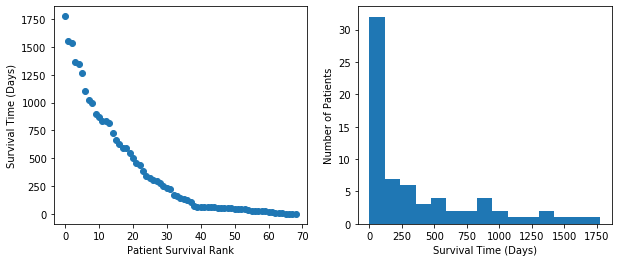

In [7]:
survival = data.survival #Since our data has multiple axes, we need to limit it to index and the data of interest.

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4)) #Define the plotting area

ax1.plot(sorted(survival)[::-1], 'o') #The data for the left plot will have patients on the x-axis sorted by their survival time, starting at the greatest and decreasing.
ax1.set_xlabel('Patient Survival Rank')
ax1.set_ylabel('Survival Time (Days)')

ax2.hist(survival, bins=15)            #Make a bin with values 15 wide
ax2.set_xlabel('Survival Time (Days)') #Note that our axes are reversed from ax1
ax2.set_ylabel('Number of Patients')

This time we used subplots; this lets us arrange multiple plots side-by-side instead of having one per code cell.

What we see is that longer survival times are less common. Some of our participants, though, could have survived years but been marked down as one week because we don't have any data past the end of the study. Let's limit it to those for whom we know the survival time is accurate:

Text(0, 0.5, 'Number of Patients')

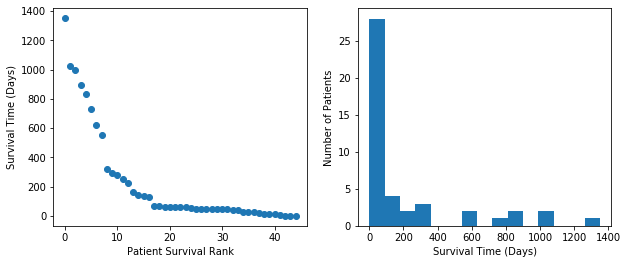

In [8]:
data = data[data.censors == 1] #Limit our data to points for which the value of the "censors" column is 1.
survival = data.survival       #Update values to the limit we just set.

#Plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.plot(sorted(survival)[::-1], 'o')
ax1.set_xlabel('Patient Survival Rank')
ax1.set_ylabel('Survival Time (Days)')

ax2.hist(survival, bins=15)
ax2.set_xlabel('Survival Time (Days)')
ax2.set_ylabel('Number of Patients')

We still have a decreasing trend, but it's decreasing much more rapidly. (Fortunatley, this is old data and our techniques have gotten much better!)

# Determining our Model

Now we get into the likelihood fitting. The first thing we need to do is choose a model; let's start with an exponentially decreasing function $y = Ae^{-x/\lambda}$. This will give us the following likelihood function:
$$ \mathscr{L}(\lambda,\{s_i\}) = P(\{s_i\} | \lambda) = \lambda^nexp(-\lambda n\bar{s})$$
Where $\bar{s}$ is the mean of the survival time:
$$ \bar{s} = \frac{1}{n}\sum s_i $$

The maximum value of the likelihood is $\lambda = 1/s$.

Let's go ahead and define some of the stuff we just talked about:

In [9]:
smean = survival.mean()
rate = 1./smean

# Preliminary Fitting Work

Now we're going to do some miscellaneous preliminary work. First, we want to generate points for plotting over the x-axis:

In [10]:
smax = survival.max()
days = np.linspace(0.,smax,1000) #generate a thousand points between 0 and the maximum survival time
# bin size: interval between two
# consecutive values in "days"
dt = smax / 999

Rather than rewriting the whole exponential distribution, let's pull it from SciPy:

In [11]:
dist_exp = st.expon.pdf(days, scale=1./rate)

Replot the histogram, adding the new distribution:

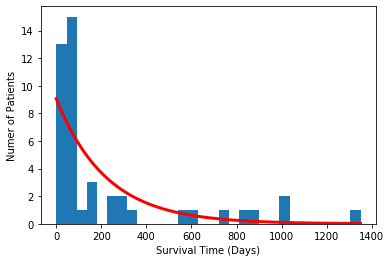

In [16]:
nbins = 30
#fig,ax = plt.subplots(1,1,figsize=(6,4))
plt.hist(survival,nbins)
plt.plot(days, dist_exp * len(survival) * smax /nbins, '-r', lw=3)
plt.xlabel("Survival Time (Days)")
plt.ylabel("Numer of Patients")
plt.show()

While in this case we were able to find the maximum likelihood analytically, we will often need to work numerically.
Let's estimate the parameters using SciPy:

In [17]:
dist = st.expon
args = dist.fit(survival)
args

(1.0, 222.2888888888889)

Left off at step 7